# End-to-end image encryption pipeline (substitution → perturbation → AES)

This notebook performs the pipeline using AES for the encryption step:

1. Load an input image and resize to 128×128 for the pipeline.
2. Apply the Fresnel-based `substitute()` row-wise (from `substitute_perbutate.py`).
3. Apply pixel perturbation (`perturbate_image`) to the substituted image.
4. Use AES to encrypt the perturbed array (bytes), then decrypt back to an array.
5. Apply inverse perturbation and inverse substitution to recover the original image.

Run the cells in order. This removes the EDNN/DDNN dependency and uses the included `aes.py` implementation instead.

In [21]:
# Core imports used across the pipeline
import numpy as np
from substitute_perbutate import FresnelSubstitution, PixelPerturbation
from PIL import Image
import matplotlib.pyplot as plt
from key_generation import key_gen
from aes import encrypt_array, decrypt_array

print('Imports ready')

Imports ready


In [22]:
# -- User-configurable parameters --
image_path = 'images.jpg'   # change to your input image file
# Substitution seeds
seed_d = 12345
seed_f = 67890
# Perturbation (logistic map) parameters
r = 3.99
x = 0.5

print('Configuration loaded:')
print(f"  image_path={image_path}")
print(f"  seeds: seed_d={seed_d}, seed_f={seed_f}")
print(f"  perturbation r={r}, x={x}")


Configuration loaded:
  image_path=images.jpg
  seeds: seed_d=12345, seed_f=67890
  perturbation r=3.99, x=0.5


Loaded image images.jpg -> resized to (128, 128)
Starting substitution (row-wise)...
  Substituting row 0/128
  Substituting row 32/128
  Substituting row 64/128
  Substituting row 96/128
Substitution completeSubstitution complete
Starting perturbation...

Starting perturbation...
Perturbation complete
Perturbation complete


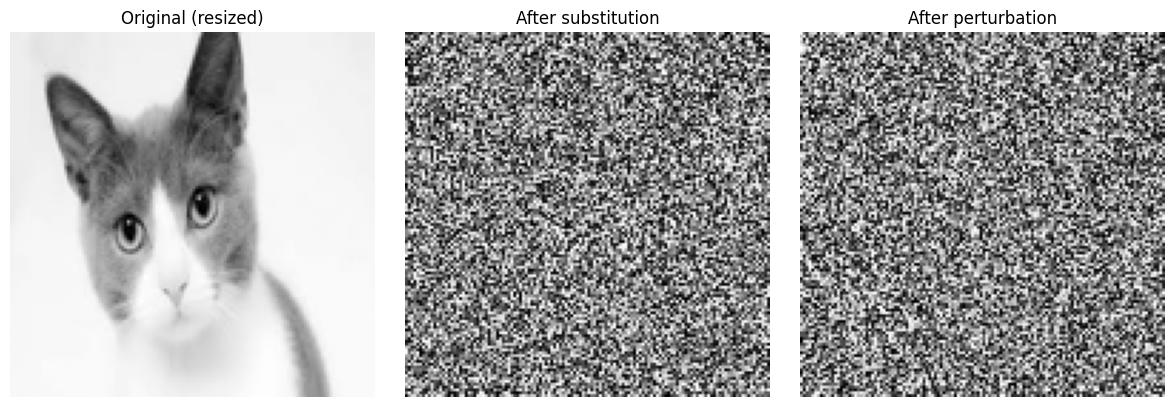

In [23]:
# Step 1: Substitution (row-wise) and Step 2: Perturbation
img = Image.open(image_path).convert('L')
# Resize to 128x128 for the pipeline
img = img.resize((128, 128))
img_array = np.array(img)
print(f"Loaded image {image_path} -> resized to {img_array.shape}")

# Substitution (row-wise)
fs = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
height, width = img_array.shape
substituted = np.zeros_like(img_array)
print('Starting substitution (row-wise)...')
for i in range(height):
    if i % 32 == 0:
        print(f"  Substituting row {i}/{height}")
    substituted[i, :] = fs.substitute(img_array[i, :])
print('Substitution complete')

# Perturbation
pp = PixelPerturbation(r_init=r, x_init=x)
pp.x_original = x
print('Starting perturbation...')
perturbed = pp.perturbate_image(substituted.copy())
print('Perturbation complete')

# Show results
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img_array, cmap='gray'); ax[0].set_title('Original (resized)'); ax[0].axis('off')
ax[1].imshow(substituted, cmap='gray'); ax[1].set_title('After substitution'); ax[1].axis('off')
ax[2].imshow(perturbed, cmap='gray'); ax[2].set_title('After perturbation'); ax[2].axis('off')
plt.tight_layout(); plt.show()


Starting AES encrypt/decrypt step...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Key generated: 32 bytes
Encrypted bytes length: 16400; iv length: 16
AES decrypt complete. Verifying equality with perturbed array...
Decrypted matches perturbed? -> True
Key generated: 32 bytes
Encrypted bytes length: 16400; iv length: 16
AES decrypt complete. Verifying equality with perturbed array...
Decrypted matches perturbed? -> True


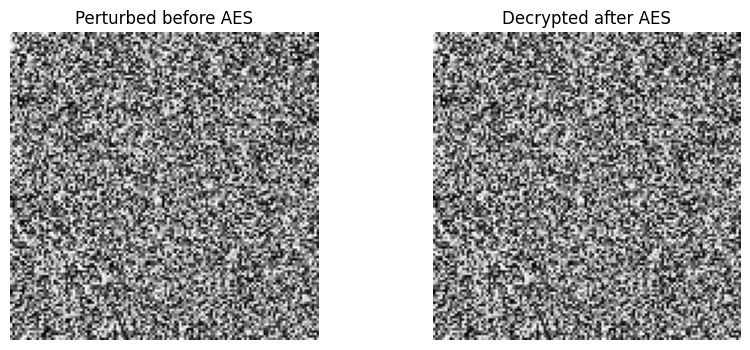

Applying inverse perturbation...
Inverse perturbation complete


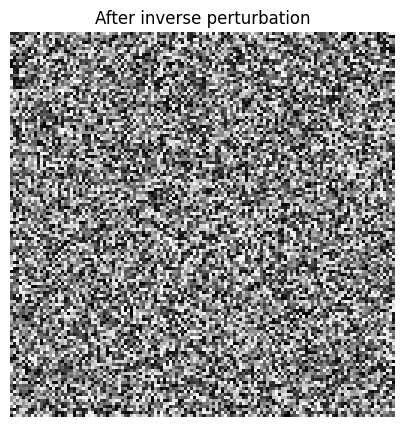

Applying inverse substitution row-wise...
  Processing row 0/128
  Processing row 32/128
  Processing row 64/128
  Processing row 96/128
Inverse substitution complete


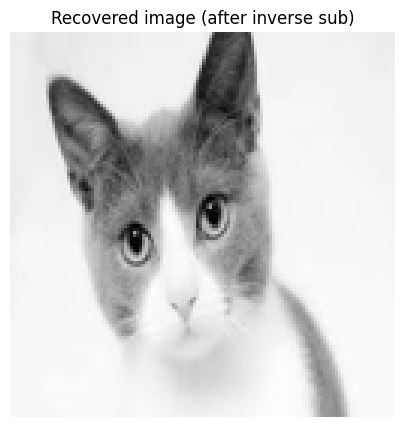

Total absolute pixel difference vs original (resized): 0


In [24]:
# AES-based encryption/decryption of the perturbed image (in-memory)
# This cell: generate key from the original image, encrypt perturbed array, decrypt it back, then run inverse perturbation and inverse substitution.
print('Starting AES encrypt/decrypt step...')
# Generate key bytes from the image (use a 256x256 resize as the key_gen expects)
# key_gen expects a NumPy array with 3 color channels matching the model input shape (256,256,3).
key_img_pil = Image.open(image_path).convert('RGB').resize((256,256))
key_img = np.array(key_img_pil).astype(np.float32)
key_bytes, key_string = key_gen(key_img)
print(f'Key generated: {len(key_bytes)} bytes')

# Encrypt the perturbed numpy array using aes.encrypt_array (returns bytes + iv + shape + dtype)
encrypted_bytes, iv, shape, dtype = encrypt_array(perturbed, key_bytes)
print(f'Encrypted bytes length: {len(encrypted_bytes)}; iv length: {len(iv)}')

# Decrypt back to numpy array
decrypted_perturbed = decrypt_array(encrypted_bytes, iv, key_bytes, shape, dtype)
print('AES decrypt complete. Verifying equality with perturbed array...')
# Quick check
eq = np.array_equal(decrypted_perturbed, perturbed)
print('Decrypted matches perturbed? ->', eq)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(perturbed, cmap='gray'); plt.title('Perturbed before AES'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(decrypted_perturbed, cmap='gray'); plt.title('Decrypted after AES'); plt.axis('off')
plt.show()

# Inverse perturbation (unscramble pixels)
pp2 = PixelPerturbation(r_init=r, x_init=x)
pp2.x_original = x
print('Applying inverse perturbation...')
inv_perturbed = pp2.perturbate_image_inverse(decrypted_perturbed.copy())
print('Inverse perturbation complete')
plt.figure(figsize=(5,5))
plt.imshow(inv_perturbed, cmap='gray')
plt.title('After inverse perturbation')
plt.axis('off')
plt.show()

# Inverse substitution (row-wise)
fs2 = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
h, w = inv_perturbed.shape
recovered = np.zeros_like(inv_perturbed)
print('Applying inverse substitution row-wise...')
for i in range(h):
    if i % 32 == 0:
        print(f'  Processing row {i}/{h}')
    recovered[i, :] = fs2.substitute_inv(inv_perturbed[i, :])
print('Inverse substitution complete')
plt.figure(figsize=(5,5))
plt.imshow(recovered, cmap='gray')
plt.title('Recovered image (after inverse sub)')
plt.axis('off')
plt.show()

# Compare with the original resized image
diff = np.sum(np.abs(recovered.astype(int) - img_array.astype(int)))
print('Total absolute pixel difference vs original (resized):', diff)


### Notes
- This replaces the EDNN/DDNN steps with AES encrypt/decrypt of the perturbed image in-memory.
- If you want to save the encrypted bytes to disk, use Python's open(..., 'wb') to write `encrypted_bytes` and store `iv` alongside it.
- The AES implementation in `aes.py` uses CBC and pads to 16 bytes. `key_bytes` must be 16/24/32 bytes for AES-128/192/256.
